In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import glob, os, psutil, time


/home/mackelab/anaconda3/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


# c) simulated data

In [ ]:

data_path = '../fits/ERC/nonlinear_fitzhughnagumo/'
fig_path = '../figs/'

pars=np.load(data_path+'pars_true.npz')['pars'].tolist()
pars_est_full   = np.load(data_path+'pars_est_full.npz')['arr_0'].tolist()['pars_est']
pars_est_partial= np.load(data_path+'pars_est_partial_cont.npz')['arr_0'].tolist()['pars_est']
pars_pca        = np.load(data_path+'pars_pca.npz')['pars'].tolist()
#pars_est_pca= np.load(data_path+'pars_est_pca.npz')['pars'].tolist()
sub_pops = np.load(data_path+'pars_est_partial_cont.npz')['arr_0'].tolist()['sub_pops']
lag_range = range(0,21,4)

idx_a = pars['idx_a']
idx_b = pars['idx_b']
pa, pb = idx_a.size, idx_b.size
x=np.load(data_path+'x.npz')['x']

p,n = pars['C'].shape
T = x.shape[0]
k,l = pars['k'],pars['l']

mmap, chunksize = True, np.min((T,p))
        
y = np.memmap(data_path+'y', dtype=np.float, mode='r', shape=(T,p))

In [ ]:
I = 0
def ddt_const(x):
    v,w = x[0],x[1]
    return np.array((v - v**3/3 -w + I, 0.08*(v +0.7-0.8*w)))

# quiver plot

N = 16
V, W = np.meshgrid(np.linspace(-2.8,2.8,N), np.linspace(-2.8,2.8,N))
dV, dW = np.zeros((N,N)), np.zeros((N,N))
for i in range(N):
    for j in range(N):
        tmp = ddt_const(np.array((V[i,j], W[i,j])))
        dV[i,j], dW[i,j] = tmp[0], tmp[1]

        
plt.figure(figsize=(1,1))
plt.quiver(V, W, dV, dW, headwidth=3.5, width=0.005,
           edgecolor='None', facecolor='b',linewidth=20, scale=105)

ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

#plt.xlim(tmin, tmax)    
#plt.xticks(range(tmin, tmax+1, 50), [str(x) for x in range(tmin, tmax+1, 50)], fontsize=14)    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
#plt.xlim(tmin, tmax)    
#plt.xticks(range(-2, 3, 2), [str(x) for x in range(-2, 3, 2)], fontsize=14)    
#plt.yticks(range(-2, 3, 2), [str(x) for x in range(-2, 3, 2)], fontsize=14)    
plt.box('off')
plt.axis('off')
plt.savefig(fig_path + 'a_quiver_tiny.pdf', bbox_inches="tight"); 

plt.show()

# c) nonlinear dynamics + linear emissions, latent and observed traces

In [ ]:
tmin, tmax = 1000, 1500

idx_showy = np.arange(15)
yshow = y[tmin:tmax,idx_showy]
ydiff = yshow.max() - yshow.min()

idx_showx = np.array([0,10,1,11,2,12])
xshow = x[tmin:tmax,idx_showx]
xdiff = xshow.max() - xshow.min()

plt.figure(figsize=(2.5,2.5))
ax = plt.subplot(111)
for i in range(idx_showy.size):
    plt.plot(range(tmin,tmax), i*ydiff + yshow[:,i], 'k')
    plt.hold(True)
    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.xlim(tmin, tmax)    
plt.xticks(range(tmin, tmax+1, 500), [str(x) for x in range(tmin, tmax+1, 500)], fontsize=14)    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.yticks([])    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.xlim(tmin, tmax)    

plt.tick_params(axis="both", which="both", top="off", left='off', right="off", labelleft="on")    
plt.box('off')

plt.savefig(fig_path + 'c_simulated_x.pdf', bbox_inches="tight"); 
plt.show()



plt.figure(figsize=(2.5,2.5))
ax = plt.subplot(111)

for i in range(idx_showx.size):
    plt.plot(range(tmin,tmax), -(xdiff+ydiff)-i*xdiff + xshow[:,i], color=[.7,.7,.7])
    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.xlim(tmin, tmax)    
plt.xticks(range(tmin, tmax+1, 500), [str(x) for x in range(tmin, tmax+1, 500)], fontsize=14)    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.yticks([])    
# Remove the tick marks
plt.tick_params(axis="both", which="both", top="off", left='off', right="off", labelleft="on")    
plt.box('off')
plt.savefig(fig_path + 'c_simulated_z.pdf', bbox_inches="tight"); 
plt.show()


# c) quality of fit (snippets of covariance matrices)

In [ ]:
sub_pops = (np.arange(5500), np.arange(4500,p))

nshow = 16
idx_a_show = np.setdiff1d(np.arange(p), sub_pops[1])
idx_b_show = np.setdiff1d(np.arange(p), sub_pops[0])

idx_a_show = idx_a_show[np.random.choice(len(idx_a_show), nshow, replace=False)]
idx_b_show = idx_b_show[np.random.choice(len(idx_b_show), nshow, replace=False)]

for m in range(1):
    print('computing time-lagged covariance for lag ', str(m))

    Qr = np.cov(y[m:m-(k+l),idx_a_show].T, y[:-(k+l),idx_b_show].T)[:idx_a_show.size,idx_b_show.size:]
    Qf = (pars_est_full['C'][idx_a_show,:].dot(pars_est_full['X'][:n,:]).dot(pars_est_full['C'][idx_b_show,:].T)) + np.diag(pars_est_full['R'])[np.ix_(idx_a_show,idx_b_show)]
    Qp = (pars_est_partial['C'][idx_a_show,:].dot(pars_est_partial['X'][:n,:]).dot(pars_est_partial['C'][idx_b_show,:].T)) + np.diag(pars_est_full['R'])[np.ix_(idx_a_show,idx_b_show)]

    cm = np.min((Qr.min(), Qf.min(), Qp.min()))
    cM = np.max((Qr.max(), Qf.max(), Qp.max()))
    
    plt.figure(figsize=(1, 1))
    plt.imshow(Qr, interpolation = 'None')
    plt.clim(cm, cM)
    plt.box('off')
    ax = plt.subplot(111)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()    
    plt.xticks([])
    plt.yticks([])
    #plt.title('true')
    plt.savefig(fig_path + 'c_simulated_true_cov.png', bbox_inches=0, pad_inches=0, frameon=False,
               transparent=True, dpi=300);   
    plt.show()
    

    plt.figure(figsize=(1, 1))
    plt.imshow(Qf, interpolation = 'None')
    plt.clim(cm, cM)
    plt.box('off')
    ax = plt.subplot(111)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()    
    plt.xticks([])
    plt.yticks([])
    #plt.title('full')
    plt.savefig(fig_path + 'c_simulated_full_cov.png', bbox_inches=0, pad_inches=0, frameon=False,
               transparent=True, dpi=300);     
    plt.show()
    

    plt.figure(figsize=(1, 1))
    plt.imshow(Qp, interpolation = 'None')
    plt.clim(cm, cM)
    plt.box('off')
    ax = plt.subplot(111)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()    
    plt.xticks([])
    plt.yticks([])
    #plt.title('stitch')
    plt.savefig(fig_path + 'c_simulated_stitch_cov.png', bbox_inches=0, pad_inches=0, frameon=False,
               transparent=True, dpi=300);     
    plt.show()


# c) combining fully / partially obs traces tau vs. corr

In [ ]:
sub_pops = (np.arange(5500), np.arange(4500,p))
idx_a = np.setdiff1d(np.arange(p), sub_pops[1])
idx_b = np.setdiff1d(np.arange(p), sub_pops[0])
pa, pb = idx_a.size, idx_b.size


corrs_true, corrs_est_full, corrs_est_partial = np.zeros(len(lag_range)), np.zeros(len(lag_range)), np.zeros(len(lag_range))
corrs_est_pca = np.zeros(len(lag_range))
kl_ = np.max(lag_range)+1
for m in range(0,len(lag_range)):
    m_ = lag_range[m]
    print('computing time-lagged covariance for lag ', str(m))
    
    Qf= np.cov(y[m_:m_-kl_,idx_a].T, y[:-kl_,idx_b].T)[:pa,pa:]   

    Qr = pars['C'][idx_a,:].dot(np.cov(x[m_:m_-kl_,:].T, x[0:-kl_,:].T)[:n,n:]).dot(pars['C'][idx_b,:].T)
    Qr = Qr + np.diag(pars['R'])[idx_a,idx_b] if m == 0 else Qr
    
    corrs_true[m] = np.corrcoef(Qf.reshape(-1), Qr.reshape(-1))[0,1]
    
    Qr = pars_est_full['C'][idx_a,:].dot(pars_est_full['X'][m*n:(m+1)*n,:]).dot(pars_est_full['C'][idx_b,:].T)

    corrs_est_full[m] = np.corrcoef(Qf.reshape(-1), Qr.reshape(-1))[0,1]

    Qr = pars_est_partial['C'][idx_a,:].dot(pars_est_partial['X'][m*n:(m+1)*n,:]).dot(pars_est_partial['C'][idx_b,:].T)

    corrs_est_partial[m] = np.corrcoef(Qf.reshape(-1), Qr.reshape(-1))[0,1]
    
    Qr = pars_pca['C'][idx_a,:].dot(pars_pca['Pi']).dot(pars_pca['C'][idx_b,:].T)
    corrs_est_pca[m] = np.corrcoef(Qf.reshape(-1), Qr.reshape(-1))[0,1]
    
   

# (comparison full vs. partial)

In [ ]:

bw = 1.2
plt.figure(figsize=(1.5, 1))
taus = lag_range
for i in range(len(taus)):
    plt.plot([taus[i]-bw, taus[i]+bw], [corrs_est_full[i],corrs_est_full[i]], '-', color='b', linewidth=1)
    plt.hold(True)
    plt.plot([taus[i]-bw, taus[i]+bw], [corrs_est_partial[i],corrs_est_partial[i]], '-', color='r', linewidth=1)

plt.axis([-bw, np.max(taus)+bw, 0.8, 1])
#plt.legend(('fully obs. fit', 'part. obs. fit', 'part. obs. PCA'), 'lower left')
plt.xlabel('time-lag [frames]', fontsize=7)
plt.ylabel('corr', fontsize=7)

ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.yticks(np.arange(0.80, 1.01, 0.1), [str(x) for x in np.arange(0.80, 1.01, 0.1)], fontsize=7)    
plt.xticks(taus, [str(x) for x in taus], fontsize=7)


ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
#plt.box('off')

plt.box('off')
plt.savefig(fig_path + 'c_simulated_performance.pdf', bbox_inches="tight"); 
plt.show()

# (comparison full vs. partial vs. partial PCA vs. ground-truth)

In [ ]:
bw = 1.2
plt.figure(figsize=(1.5, 1))
taus = lag_range
for i in range(len(taus)):
    plt.plot([taus[i]-bw, taus[i]+bw], [corrs_est_full[i],corrs_est_full[i]], '-', color='b', linewidth=0.5)
    plt.hold(True)
    plt.plot([taus[i]-bw, taus[i]+bw], [corrs_est_partial[i],corrs_est_partial[i]], '-', color='r', linewidth=0.5)
    plt.plot([taus[i]-bw, taus[i]+bw], [corrs_est_pca[i],corrs_est_pca[i]], '-', color='k', linewidth=0.5)
    plt.plot([taus[i]-bw, taus[i]+bw], [corrs_true[i],corrs_true[i]], '-', color='g', linewidth=0.5)

    
plt.axis([-bw, np.max(taus)+bw, -0.2, 1])
#plt.legend(('fully obs. fit', 'part. obs. fit', 'part. obs. PCA'), 'lower left')
plt.xlabel('time-lag [frames]', fontsize=7)
plt.ylabel('corr', fontsize=7)

ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.axis([-bw, np.max(taus)+bw, -0.3, 1.01])
plt.yticks(np.arange(0.0, 1.01, 0.5), [str(x) for x in np.arange(0.0, 1.01, 0.5)], fontsize=7)    
plt.xticks(taus, [str(x) for x in taus], fontsize=7)

plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
#plt.box('off')

plt.box('off')
plt.savefig(fig_path + 'c_simulated_performance_pca_grtr.pdf', bbox_inches="tight"); 
plt.show()


In [ ]:
from sklearn.decomposition import PCA

fig_path = '/home/mackelab/Desktop/Projects/Stitching/code/le_stitch/python/figs/'
m_range = range(len(lag_range))
kl_ = np.max(lag_range)+1

y_masked = np.memmap(data_path+'y_zscore', dtype=np.float, mode='c', shape=(T,p))

#y_masked[:obs_time[0], np.setdiff1d(np.arange(p), sub_pops[obs_pops[0]])] = 0
#for i in range(1,len(obs_time)):
#    y_masked[np.ix_(np.arange(obs_time[i-1],obs_time[i]), np.setdiff1d(np.arange(p), sub_pops[obs_pops[i]]))] = 0
    
pca = PCA()
pca.fit(y_masked)
del y_masked

pars_pca = {}
pars_pca['C'] = pca.components_[:n].T
pars_pca['Pi'] = np.diag(pca.explained_variance_[:n])    


idxc_a = np.setdiff1d(np.arange(p), sub_pops[1])
if len(sub_pops) > 0:
    idxc_b = np.setdiff1d(np.arange(p), sub_pops[0]) # those only in subpop #2 
else:
    idxc_b = idx_a.copy()
pa, pb = len(idxc_a), len(idxc_b)

pa, pb = 1000, 1000
idxc_a = idxc_a[np.sort(np.random.choice(idxc_a.size, pa, replace=False))] # subsample for \
idxc_b = idxc_b[np.sort(np.random.choice(idxc_b.size, pb, replace=False))] # memory reasons


Qs = []
if mmap:
    y = np.memmap(data_path+'y_zscore', dtype=np.float, mode='r', shape=(T,p))
    

corrs_est = np.zeros((len(m_range), 2))
MSE_est = np.zeros((len(m_range), 2))    
for m in m_range:
    m_ = lag_range[m]
    print('computing time-lagged covariance for lag ', str(m_))
    Qs.append(None)
    if mmap:
        Q = np.memmap(data_path+'Qs_'+str(m_), dtype=np.float, 
                      mode='w+', shape=(pa,pb))
    else:
        Q = np.empty((pa,pb))
    Q[:] = np.cov(y[m_:m_-(kl_),idxc_a].T, y[:-(kl_),idxc_b].T)[:pa,pa:]     
    if mmap:
        del Q
        Qs[m] = np.memmap(data_path+'Qs_'+str(m_), dtype=np.float, 
                          mode='r', shape=(pa,pb))
    else:
        Qs[m] = Q
            
    Q = (pars_est['C'][idxc_a,:].dot(pars_est['X'][m*n:(m+1)*n,:]).dot(pars_est['C'][idxc_b,:].T))
    corrs_est[m,0] = np.corrcoef(Qs[m][:].reshape(-1), Q.reshape(-1))[0,1]
    MSE_est[m,0] = np.mean( (Qs[m] - Q)**2 )

    """
    plt.figure(figsize=(20,20))
    if m_ == 0:
        plt.plot(-10,-10, 'r.')    
        plt.hold(True)
        plt.plot(-10,-10, 'b.')    
        plt.plot(Qs[m][:], Q[:], 'r.')
        plt.hold(True)
        plt.title('corr. est. us:' + str(np.corrcoef(Qs[m][:].reshape(-1), Q.reshape(-1))[0,1]))
    """
    
    tmp  = np.abs(Q.reshape(-1) - Qs[m].reshape(-1))
        
    Q = (pars_pca['C'][idxc_a,:].dot(pars_pca['Pi']).dot(pars_pca['C'][idxc_b,:].T))
    corrs_est[m,1] = np.corrcoef(Qs[m][:].reshape(-1), Q.reshape(-1))[0,1]      
    MSE_est[m,1] = np.mean( (Qs[m] - Q)**2 )    
    
    """
    if m_ == 0:
        plt.plot(Qs[m][:], Q[:], 'b.')
        plt.plot([-1,1], [-1,1], 'k--')

        plt.legend(('stitched', 'naive PCA'), 'northwest')    
        plt.axis([-1,1,-1,1])
        plt.xlabel('corr. est. PCA:' + str(np.corrcoef(Qs[m][:].reshape(-1), Q.reshape(-1))[0,1]))
        plt.savefig(fig_path + 'stitched_covs.png', bbox_inches="tight"); 
        plt.show()
    """
    
    del Q
    if mmap:
        del y # releases RAM, forces flush to disk
        y = np.memmap(data_path+'y_zscore', dtype=np.float, mode='r', shape=(T,p)) 


# scatter plot

In [ ]:
sub_pops = (np.arange(5500), np.arange(4500,p))
idx_a = np.setdiff1d(np.arange(p), sub_pops[1])
idx_b = np.setdiff1d(np.arange(p), sub_pops[0])
idx_a = idx_a[np.random.choice(idx_a.size, 1000, replace=False)]
idx_b = idx_b[np.random.choice(idx_b.size, 1000, replace=False)]
pa, pb = idx_a.size, idx_b.size

sub_pops = np.load(data_path+'pars_est_partial_cont.npz')['arr_0'].tolist()['sub_pops']
obs_time = np.array([T//2, T])
obs_pops = np.arange(len(sub_pops))
y_masked = np.memmap(data_path+'y', dtype=np.float, mode='c', shape=(T,p))
y_masked[:obs_time[0], np.setdiff1d(np.arange(p), sub_pops[obs_pops[0]])] = 0
for i in range(1,len(obs_time)):
    y_masked[np.ix_(np.arange(obs_time[i-1],obs_time[i]), np.setdiff1d(np.arange(p), sub_pops[obs_pops[i]]))] = 0    
pca = PCA()
pca.fit(y_masked)
del y_masked
pars_pca = {}
pars_pca['C'] = pca.components_[:n].T
pars_pca['Pi'] = np.diag(pca.explained_variance_[:n])   


kl_ = np.max(lag_range)+1
for m in range(1):
    m_ = lag_range[m]
    print('computing time-lagged covariance for lag ', str(m))
    
    Qemp = np.cov(y[m_:m_-kl_,idx_a].T, y[:-kl_,idx_b].T)[:pa,pa:]       
    
    Qfull = pars_est_full['C'][idx_a,:].dot(pars_est_full['X'][m*n:(m+1)*n,:]).dot(pars_est_full['C'][idx_b,:].T)


    Qstitch = pars_est_partial['C'][idx_a,:].dot(pars_est_partial['X'][m*n:(m+1)*n,:]).dot(pars_est_partial['C'][idx_b,:].T)

    
    Qpca = pars_pca['C'][idx_a,:].dot(pars_pca['Pi']).dot(pars_pca['C'][idx_b,:].T)
    

In [ ]:

plt.figure(figsize=(1.2,1.2))
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.plot(Qemp.reshape(-1), Qstitch.reshape(-1), 'r.', markersize=1)
plt.hold(True)
plt.plot(Qemp.reshape(-1), Qfull.reshape(-1), 'b.', markersize=1)
plt.plot(Qemp.reshape(-1), Qpca.reshape(-1), 'k.', markersize=1)
#plt.xlabel('true cov.', fontsize=7)
#plt.ylabel('est. cov.', fontsize=7)
plt.xticks(range(-1,2), ['' for x in range(-1,2)], fontsize=7)
plt.yticks(range(-1,2), ['' for x in range(-1,2)], fontsize=7)
plt.axis('equal')
plt.box('off')
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
plt.savefig(fig_path + 'c_simulated_scatter_with_pca_no_ticks.png', bbox_inches="tight", pad_inches=0, frameon=False,
               transparent=True, dpi=300);   
plt.show()

In [ ]:

plt.figure(figsize=(1.2,1.2))
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.plot(Qemp.reshape(-1), Qstitch.reshape(-1), 'r.', markersize=1)
plt.hold(True)
#plt.plot(Qemp.reshape(-1), Qpca.reshape(-1), 'k.', markersize=1)
plt.plot(Qemp.reshape(-1), Qfull.reshape(-1), 'b.', markersize=1)
#plt.xlabel('true cov.', fontsize=7)
#plt.ylabel('est. cov.', fontsize=7)
plt.xticks(range(-1,2), ['' for x in range(-1,2)], fontsize=7)
plt.yticks(range(-1,2), ['' for x in range(-1,2)], fontsize=7)
plt.axis('equal')
plt.box('off')
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
plt.savefig(fig_path + 'c_simulated_scatter_no_ticks.png', bbox_inches="tight", pad_inches=0, frameon=False,
               transparent=True, dpi=300);   
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data_path = '../fits/ERC/nonlinear_fitzhughnagumo/'
fig_path = '../figs/'
tmin, tmax = 1000, 1500

idx_showx = np.array([0,10,1,11,2,12,3,13,4,14,5,15,6,16,7,17,8,18,9,19]) 
#idx_showx = np.array([0,10,1,11,2,12])

pars_est_partial=np.load(data_path+'pars_est_partial_cont.npz')['arr_0'].tolist()['pars_est']
pars_est_full=np.load(data_path+'pars_est_full.npz')['arr_0'].tolist()['pars_est']
pars=np.load(data_path+'pars_true.npz')['pars'].tolist()
p,n = pars['C'].shape
x=np.load(data_path+'x.npz')['x']
T = x.shape[0]

y = np.memmap(data_path+'y', dtype=np.float, mode='r', shape=(T,p))

xshow = x[tmin:tmax,idx_showx]
xdiff = xshow.max() - xshow.min()

%matplotlib inline
idx_t = np.arange(tmin, tmax)
idx_x = idx_showx.copy()

Cd_true = np.linalg.pinv(pars['C'])

Cd_est_full  = np.linalg.pinv(pars_est_full['C'])

x_est_raw = Cd_est_full.dot(y.T)
Qfull = np.linalg.inv(x_est_raw.dot(np.linalg.pinv(x.T)))

#Qfull = np.linalg.pinv(Cd_est_full.dot(pars['C']))
x_est_full = (Cd_est_full.dot(y[idx_t,:].T).T).dot(Qfull.T)

Cd_est_partial  = np.linalg.pinv(pars_est_partial['C'])

x_est_raw = Cd_est_partial.dot(y.T)
Qpartial = np.linalg.inv(x_est_raw.dot(np.linalg.pinv(x.T)))
#Qpartial = np.linalg.pinv(Cd_est_partial.dot(pars['C']))
x_est_partial = ((Cd_est_partial.dot(y[idx_t,:].T)).T).dot(Qpartial.T)

plt.figure(figsize=(10,10))

plot_stitched = True
if plot_stitched:
    xdiff *= 1.5
for i in range(len(idx_x)): #range(len(idx_x)):
    
    plt.plot(range(tmin,tmax), -i*xdiff + x[idx_t,idx_x[i]], 'k')
    plt.hold(True)
    #plt.plot(range(tmin,tmax), -i*xdiff + Cd_true.dot(y[idx_t,:].T).T[:,idx_x[i]], 'r')
    plt.plot(range(tmin,tmax), -i*xdiff + x_est_full[:,idx_x[i]], 'g', linewidth=0.5)
    
    if plot_stitched:
        plt.plot(range(tmin,tmax), -i*xdiff + x_est_partial[:,idx_x[i]], 'b', linewidth=0.5)

ax = plt.subplot(111)    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.xlim(tmin, tmax)    
plt.xticks(range(tmin, tmax+1, 500), [str(x) for x in range(tmin, tmax+1, 500)], fontsize=14)    

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.yticks([])    
plt.xlabel('time t', fontsize=14)
# Remove the tick marks
plt.tick_params(axis="both", which="both", top="off", left='off', right="off", labelleft="on")    
plt.box('off')
#plt.savefig(fig_path + 'c_identifying_z_select_plus_stitched.pdf', bbox_inches="tight"); 
plt.show()

In [ ]:
plt.imshow(Qfull, interpolation='None')
plt.colorbar()
plt.show()
np.abs(np.linalg.eigvals(Qfull))

In [ ]:
plt.imshow(Qpartial, interpolation='None')
plt.colorbar()
plt.show()

np.abs(np.linalg.eigvals(Qpartial))

In [ ]:
lag_range = range(0,21,4)
kl_ = np.max(lag_range)+1

plt.figure(figsize=(6,len(lag_range)*3))

#tmp = Qpartial.copy()
tmp = np.eye(n)

for m in range(len(lag_range)):
    m_ = lag_range[m]
    Qf= np.cov(x[m_:m_-kl_,:].T, x[:-kl_,:].T)[:n,n:]    
    Qr= tmp.dot(pars_est_partial['X'][m*n:(m+1)*n]).dot(tmp.T)
    
    plt.subplot(len(lag_range),2,2*m+1)
    plt.imshow(Qf, interpolation='None')
    plt.ylabel('time-lag = ' + str(m_), fontsize=14)
    plt.title('ground-truth')
    plt.colorbar()
    plt.gray()
    plt.subplot(len(lag_range),2,2*m+2)
    plt.imshow(Qr, interpolation='None')
    plt.title('estimated')
    plt.colorbar()
    plt.gray()
plt.savefig(fig_path + 'c_identifying_z_covs_stitched.pdf', bbox_inches="tight"); 
plt.show()
    

In [ ]:
lag_range = range(0,21,4)
kl_ = np.max(lag_range)+1

plt.figure(figsize=(6,len(lag_range)*3))

for m in range(len(lag_range)):
    m_ = lag_range[m]
    Qf= np.cov(x[m_:m_-kl_,:].T, x[:-kl_,:].T)[:n,n:]    
    Qr= Qfull.dot(pars_est_full['X'][m*n:(m+1)*n]).dot(Qfull.T)
    
    plt.subplot(len(lag_range),2,2*m+1)
    plt.imshow(Qf, interpolation='None')
    plt.ylabel('time-lag = ' + str(m_), fontsize=14)
    plt.title('ground-truth')
    plt.colorbar()
    plt.gray()
    plt.subplot(len(lag_range),2,2*m+2)
    plt.imshow(Qr, interpolation='None')
    plt.title('estimated')
    plt.colorbar()
    plt.gray()
plt.savefig(fig_path + 'c_identifying_z_covs.pdf', bbox_inches="tight"); 
plt.show()
    

In [ ]:
Qf.shape








# d) real data

In [2]:

data_path = '../fits/lsfm/grid_quick/'
fig_path = '../figs/'

tmp = np.load(data_path + 'stitch_2pops_zsplit_6_lags.npz')
p,n,T = tmp['p'],tmp['n'],tmp['T']
lag_range = tmp['lag_range']
pars_est_partial = tmp['pars_est'].tolist()
sub_pops = tmp['sub_pops']
obs_pops = np.arange(len(sub_pops))
obs_time = T//len(sub_pops) * np.arange(1,len(sub_pops)+1)
    
tmp = np.load(data_path + 'full_2pops_zsplit_6_lags.npz')
pars_est_full = tmp['pars_est'].tolist()
y = np.memmap(data_path+'y_zscore', dtype=np.float, mode='r', shape=(T,p))



In [ ]:
nz, nx, ny = 41, 1024, 2048
filename = '/home/mackelab/data/dOMR0_20150414_112406/TM00000_CM0_CHN00.stack'
stack = np.fromfile(filename, dtype=np.float16).reshape(nz, nx, ny).astype(dtype=np.float32)

def sig(x):
    return 1/(1+np.exp(-x/2.5))
    #return x

for z in [3, 10, 17]:
    plt.figure(figsize=(0.6,1.2))
    plt.imshow( sig((stack[z,:,:].T-stack[z,:,:].mean())/np.sqrt(np.var(stack[z,:,:]))), interpolation='None')
    plt.gray()
    #plt.title('z =' + str(z), fontsize=14)
    #plt.yticks([0, 1024, 2048], [str(x) for x in [0, 1024, 2048]], fontsize=14)
    #plt.xticks([0, 1024], [str(x) for x in [0, 1024]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    plt.box('off')
    plt.savefig(fig_path + 'a_frame0_z'+ str(z+1) +'.png', bbox_inches=0, pad_inches=0, frameon=False,
               transparent=True, dpi=300); 
    plt.show()

In [ ]:
nz, nx, ny = 41, 1024, 2048
filename = '/home/mackelab/data/dOMR0_20150414_112406/TM00000_CM0_CHN00.stack'
stack = np.fromfile(filename, dtype=np.float16).reshape(nz, nx, ny).astype(dtype=np.float32)

def sig(x):
    return 1/(1+np.exp(-x/1.5))
    #return x

for z in [10,14,16]:
    plt.figure(figsize=(0.8,1.6))
    plt.imshow( sig((stack[z,:,:].T-stack[z,:,:].mean())/np.sqrt(np.var(stack[z,:,:]))), interpolation='None')
    plt.gray()
    #plt.title('z =' + str(z), fontsize=14)
    #plt.yticks([0, 1024, 2048], [str(x) for x in [0, 1024, 2048]], fontsize=14)
    #plt.xticks([0, 1024], [str(x) for x in [0, 1024]], fontsize=14)
    plt.xticks([])
    plt.yticks([])
    #plt.box('off')
    plt.savefig(fig_path + 'd_frame0_z'+ str(z+1) +'.png', bbox_inches=0, pad_inches=0, frameon=False,
               transparent=True, dpi=300); 
    plt.show()

# real data traces (tiny)

In [ ]:
tmin, tmax = 790, 910
ts = np.arange(tmin, tmax)


for j in range(3):
    idx_showy = np.random.choice(p, 8, replace=False)
    yshow = y[np.ix_(ts,idx_showy)]
    ydiff = 0.66*(yshow.max() - yshow.min())

    plt.figure(figsize=(0.9,0.8))
    ax = plt.subplot(111)
    for i in range(idx_showy.size):
        plt.plot(range(tmin,tmax), i*ydiff + yshow[:,i], 'k', linewidth=0.5)
        plt.hold(True)

    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()    

    plt.xlim(tmin-5, tmax+5)    
    plt.xticks([])
    #plt.xticks([800,900], [str(x) for x in [800,900]], fontsize=7)    
    plt.yticks([])    


    plt.tick_params(axis="both", which="both", top="off", left='off', right="off", labelleft="on",tickdir='out')    
    #plt.box('off')

    plt.savefig(fig_path + 'a_data_traces_' + str(j+1) + '.pdf', bbox_inches="tight"); 
    plt.show()


In [ ]:
# real data traces (small)

In [ ]:
tmin, tmax = 790, 910
ts = np.arange(tmin, tmax)


for j in range(3):
    idx_showy = np.random.choice(p, 12, replace=False)
    yshow = y[np.ix_(ts,idx_showy)]
    ydiff = 0.66*(yshow.max() - yshow.min())

    plt.figure(figsize=(1.2,1.2))
    ax = plt.subplot(111)
    for i in range(idx_showy.size):
        plt.plot(range(tmin,tmax), i*ydiff + yshow[:,i], 'k', linewidth=0.5)
        plt.hold(True)

    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()    

    plt.xlim(tmin-5, tmax+5)    
    plt.xticks([])
    #plt.xticks([800,900], [str(x) for x in [800,900]], fontsize=7)    
    plt.yticks([])    


    plt.tick_params(axis="both", which="both", top="off", left='off', right="off", labelleft="on",tickdir='out')    
    plt.box('off')

    plt.savefig(fig_path + 'd_data_traces_' + str(j+1) + '.pdf', bbox_inches="tight"); 
    plt.show()


# d) quality of fit (snippets of covariance matrices)

computing time-lagged covariance for lag  0


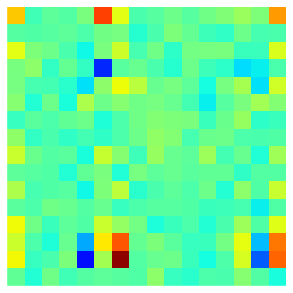

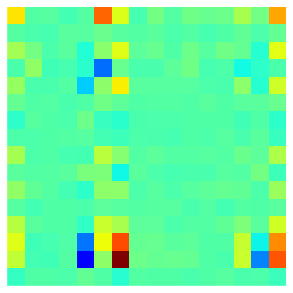

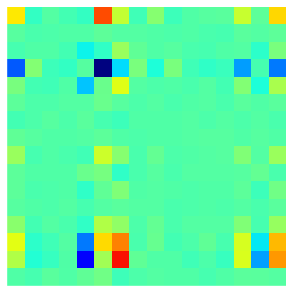

In [7]:
nshow = 16
idx_a_show = np.setdiff1d(np.arange(p), sub_pops[1])
idx_b_show = np.setdiff1d(np.arange(p), sub_pops[0])

idx_a_show = idx_a_show[np.random.choice(len(idx_a_show), nshow, replace=False)]
idx_b_show = idx_b_show[np.random.choice(len(idx_b_show), nshow, replace=False)]


kl_ = np.max(lag_range)+1
for m in range(1):
    print('computing time-lagged covariance for lag ', str(m))
    m_ = lag_range[m]
    
    Qr = np.cov(y[m_:m_-kl_,idx_a_show].T, y[:-kl_,idx_b_show].T)[:idx_a_show.size,idx_b_show.size:]
    Qf = (pars_est_full['C'][idx_a_show,:].dot(pars_est_full['X'][:n,:]).dot(pars_est_full['C'][idx_b_show,:].T)) + np.diag(pars_est_full['R'])[np.ix_(idx_a_show,idx_b_show)]
    Qp = (pars_est_partial['C'][idx_a_show,:].dot(pars_est_partial['X'][:n,:]).dot(pars_est_partial['C'][idx_b_show,:].T)) + np.diag(pars_est_full['R'])[np.ix_(idx_a_show,idx_b_show)]

    cm = np.min((Qr.min(), Qf.min(), Qp.min()))
    cM = np.max((Qr.max(), Qf.max(), Qp.max()))
    
    plt.figure(figsize=(5, 5))
    plt.imshow(Qr, interpolation = 'None')
    plt.clim(cm, cM)
    plt.box('off')
    ax = plt.subplot(111)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()    
    plt.xticks([])
    plt.yticks([])
    plt.savefig(fig_path + 'd_lsfm_true_cov.png', bbox_inches=0, pad_inches=0, frameon=False,
               transparent=True, dpi=300);     
    plt.show()
    

    plt.figure(figsize=(5, 5))
    plt.imshow(Qf, interpolation = 'None')
    plt.clim(cm, cM)
    plt.box('off')
    ax = plt.subplot(111)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()    
    plt.xticks([])
    plt.yticks([])
    plt.savefig(fig_path + 'd_lsfm_full_cov.png', bbox_inches=0, pad_inches=0, frameon=False,
               transparent=True, dpi=300);     
    plt.show()
    

    plt.figure(figsize=(5, 5))
    plt.imshow(Qp, interpolation = 'None')
    plt.clim(cm, cM)
    plt.box('off')
    ax = plt.subplot(111)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()    
    plt.xticks([])
    plt.yticks([])
    plt.savefig(fig_path + 'd_lsfm_stitch_cov.png', bbox_inches=0, pad_inches=0, frameon=False,
               transparent=True, dpi=300);     
    plt.show()


computing time-lagged covariance for lag  0


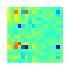

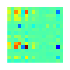

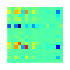

In [17]:

idx_a_show = idx_a_show[np.random.choice(len(idx_a_show), nshow, replace=False)]
idx_b_show = idx_b_show[np.random.choice(len(idx_b_show), nshow, replace=False)]
kl_ = np.max(lag_range)+1
for m in range(1):
    print('computing time-lagged covariance for lag ', str(m))
    m_ = lag_range[m]
    
    Qr = np.cov(y[m_:m_-kl_,idx_a_show].T, y[:-kl_,idx_b_show].T)[:idx_a_show.size,idx_b_show.size:]
    Qf = (pars_est_full['C'][idx_a_show,:].dot(pars_est_full['X'][:n,:]).dot(pars_est_full['C'][idx_b_show,:].T)) + np.diag(pars_est_full['R'])[np.ix_(idx_a_show,idx_b_show)]
    Qp = (pars_est_partial['C'][idx_a_show,:].dot(pars_est_partial['X'][:n,:]).dot(pars_est_partial['C'][idx_b_show,:].T)) + np.diag(pars_est_full['R'])[np.ix_(idx_a_show,idx_b_show)]

    cm = np.min((Qr.min(), Qf.min(), Qp.min()))
    cM = np.max((Qr.max(), Qf.max(), Qp.max()))
    
    plt.figure(figsize=(1, 1))
    plt.imshow(Qr, interpolation = 'None')
    plt.clim(cm, cM)
    plt.box('off')
    ax = plt.subplot(111)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()    
    plt.xticks([])
    plt.yticks([])
    plt.savefig(fig_path + 'd_lsfm_true_cov.png', bbox_inches=0, pad_inches=0, frameon=False,
               transparent=True, dpi=300);     
    plt.show()
    

    plt.figure(figsize=(1, 1))
    plt.imshow(Qf, interpolation = 'None')
    plt.clim(cm, cM)
    plt.box('off')
    ax = plt.subplot(111)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()    
    plt.xticks([])
    plt.yticks([])
    plt.savefig(fig_path + 'd_lsfm_full_cov.png', bbox_inches=0, pad_inches=0, frameon=False,
               transparent=True, dpi=300);     
    plt.show()
    

    plt.figure(figsize=(1, 1))
    plt.imshow(Qp, interpolation = 'None')
    plt.clim(cm, cM)
    plt.box('off')
    ax = plt.subplot(111)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()    
    plt.xticks([])
    plt.yticks([])
    plt.savefig(fig_path + 'd_lsfm_stitch_cov.png', bbox_inches=0, pad_inches=0, frameon=False,
               transparent=True, dpi=300);     
    plt.show()


In [18]:
idx_a_show, idx_b_show

(array([3205, 2640, 1577, 2920, 2261, 1995, 2527, 3220,   72, 1924, 4494,
        4839, 3188, 1821, 3889, 2110]),
 array([ 7534,  7193,  7737,  6838,  7415,  9753,  6819, 10780,  6889,
         9310,  7364,  6286, 10819,  8312,  9557,  6593]))

# d) combining fully / partially obs traces tau vs. corr

In [ ]:
from sklearn.decomposition import PCA
y_masked = np.memmap(data_path+'y_zscore', dtype=np.float, mode='c', shape=(T,p))
y_masked[:obs_time[0], np.setdiff1d(np.arange(p), sub_pops[obs_pops[0]])] = 0
for i in range(1,len(obs_time)):
    y_masked[np.ix_(np.arange(obs_time[i-1],obs_time[i]), np.setdiff1d(np.arange(p), sub_pops[obs_pops[i]]))] = 0
    
pca = PCA()
pca.fit(y_masked)
del y_masked
pars_pca = {}
pars_pca['C'] = pca.components_[:n].T
pars_pca['Pi'] = np.diag(pca.explained_variance_[:n])    

print('done PCA')

In [ ]:
idx_a = np.setdiff1d(np.arange(p), sub_pops[1])
idx_b = np.setdiff1d(np.arange(p), sub_pops[0])
pa, pb = idx_a.size, idx_b.size


corrs_est_full, corrs_est_partial = np.zeros(len(lag_range)), np.zeros(len(lag_range))
corrs_est_pca = np.zeros(len(lag_range))
kl_ = np.max(lag_range)+1
for m in range(len(lag_range)):
    m_ = lag_range[m]
    print('computing time-lagged covariance for lag ', str(m_))
    Q = np.cov(y[m_:m_-kl_,idx_a].T, y[:-kl_,idx_b].T)[:pa,pa:]     
    Qf= np.cov(y[m_:m_-kl_,idx_a].T, y[:-kl_,idx_b].T)[:pa,pa:]   
    
    Qr = pars_est_full['C'][idx_a,:].dot(pars_est_full['X'][m*n:(m+1)*n,:]).dot(pars_est_full['C'][idx_b,:].T)

    corrs_est_full[m] = np.corrcoef(Qf.reshape(-1), Qr.reshape(-1))[0,1]

    Qr = pars_est_partial['C'][idx_a,:].dot(pars_est_partial['X'][m*n:(m+1)*n,:]).dot(pars_est_partial['C'][idx_b,:].T)

    corrs_est_partial[m] = np.corrcoef(Qf.reshape(-1), Qr.reshape(-1))[0,1]
    
    Qr = pars_pca['C'][idx_a,:].dot(pars_pca['Pi']).dot(pars_pca['C'][idx_b,:].T)
    corrs_est_pca[m] = np.corrcoef(Qf.reshape(-1), Qr.reshape(-1))[0,1]


# (comparison full vs. partial)

In [ ]:

bw = 1.2
plt.figure(figsize=(1.5, 1))
taus = lag_range
for i in range(len(taus)):
    plt.plot([taus[i]-bw, taus[i]+bw], [corrs_est_full[i],corrs_est_full[i]], '-', color='b', linewidth=1)
    plt.hold(True)
    plt.plot([taus[i]-bw, taus[i]+bw], [corrs_est_partial[i],corrs_est_partial[i]], '-', color='r', linewidth=1)

#plt.legend(('fully obs. fit', 'part. obs. fit', 'part. obs. PCA'), 'lower left')
plt.xlabel('time-lag [frames]', fontsize=7)
plt.ylabel('corr', fontsize=7)

ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    


plt.axis([-bw, np.max(taus)+bw, 0.45, 0.67])
plt.yticks(np.arange(0.45, 0.66, 0.1), [str(x) for x in np.arange(0.45, 0.66, 0.1)], fontsize=7)    
plt.xticks(taus, [str(x) for x in taus], fontsize=7)

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
#plt.box('off')

plt.box('off')
plt.savefig(fig_path + 'd_lsfm_performance.pdf', bbox_inches="tight"); 
plt.show()

# (comparison full vs. partial vs. partial PCA vs. ground-truth)

In [ ]:

bw = 1.2
plt.figure(figsize=(1.5, 1))
taus = lag_range
for i in range(len(taus)):
    plt.plot([taus[i]-bw, taus[i]+bw], [corrs_est_full[i],corrs_est_full[i]], '-', color='b', linewidth=0.5)
    plt.hold(True)
    plt.plot([taus[i]-bw, taus[i]+bw], [corrs_est_partial[i],corrs_est_partial[i]], '-', color='r', linewidth=0.5)
    plt.plot([taus[i]-bw, taus[i]+bw], [corrs_est_pca[i],corrs_est_pca[i]], '-', color='k', linewidth=0.5)

    
plt.axis([-bw, np.max(taus)+bw, 0.45, 0.71])
plt.xlabel('time-lag [frames]', fontsize=7)
plt.ylabel('corr', fontsize=7)

ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.yticks(np.arange(0.4, 0.71, 0.1), [str(x) for x in np.arange(0.4, 0.71, 0.1)], fontsize=7)    
plt.xticks(taus, [str(x) for x in taus], fontsize=7)

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
#plt.box('off')

plt.box('off')
#plt.legend(('fully obs. fit', 'part. obs. fit', 'part. obs. PCA'), 'upper right')
plt.savefig(fig_path + 'd_lsfm_performance_pca.pdf', bbox_inches="tight"); 
plt.show()



# scatter plot

In [ ]:
idx_a = np.setdiff1d(np.arange(p), sub_pops[1])
idx_b = np.setdiff1d(np.arange(p), sub_pops[0])
idx_a = idx_a[np.random.choice(idx_a.size, 1000, replace=False)]
idx_b = idx_b[np.random.choice(idx_b.size, 1000, replace=False)]
pa, pb = idx_a.size, idx_b.size

y_masked = np.memmap(data_path+'y_zscore', dtype=np.float, mode='c', shape=(T,p))
y_masked[:obs_time[0], np.setdiff1d(np.arange(p), sub_pops[obs_pops[0]])] = 0
for i in range(1,len(obs_time)):
    y_masked[np.ix_(np.arange(obs_time[i-1],obs_time[i]), np.setdiff1d(np.arange(p), sub_pops[obs_pops[i]]))] = 0    
pca = PCA()
pca.fit(y_masked)
del y_masked
pars_pca = {}
pars_pca['C'] = pca.components_[:n].T
pars_pca['Pi'] = np.diag(pca.explained_variance_[:n])   


kl_ = np.max(lag_range)+1
for m in range(1):
    m_ = lag_range[m]
    print('computing time-lagged covariance for lag ', str(m))
    
    Qemp = np.cov(y[m_:m_-kl_,idx_a].T, y[:-kl_,idx_b].T)[:pa,pa:]       
    
    Qfull = pars_est_full['C'][idx_a,:].dot(pars_est_full['X'][m*n:(m+1)*n,:]).dot(pars_est_full['C'][idx_b,:].T)


    Qstitch = pars_est_partial['C'][idx_a,:].dot(pars_est_partial['X'][m*n:(m+1)*n,:]).dot(pars_est_partial['C'][idx_b,:].T)

    
    Qpca = pars_pca['C'][idx_a,:].dot(pars_pca['Pi']).dot(pars_pca['C'][idx_b,:].T)
    

In [ ]:

plt.figure(figsize=(1.2,1.2))
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.plot(Qemp.reshape(-1), Qstitch.reshape(-1), 'r.', markersize=1)
plt.hold(True)
plt.plot(Qemp.reshape(-1), Qfull.reshape(-1), 'b.', markersize=1)
plt.plot(Qemp.reshape(-1), Qpca.reshape(-1), 'k.', markersize=1)
plt.box('off')
#plt.xlabel('true cov.', fontsize=7)
#plt.ylabel('est. cov.', fontsize=7)
#plt.xticks(np.arange(-0.49,0.9,0.5), [str(x) for x in [-0.5,0,0.5]], fontsize=7)
#plt.yticks(np.arange(-0.49,0.9,0.5), [str(x) for x in [-0.5,0,0.5]], fontsize=7)
plt.xticks(np.arange(-0.49,0.9,0.5), ['' for x in [-0.5,0,0.5]], fontsize=7)
plt.yticks(np.arange(-0.49,0.9,0.5), ['' for x in [-0.5,0,0.5]], fontsize=7)
plt.axis('equal')
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
plt.savefig(fig_path + 'd_lsfm_scatter_with_pca_no_ticks.png', bbox_inches="tight", pad_inches=0, frameon=False,
               transparent=True, dpi=300);   
plt.show()

In [ ]:

plt.figure(figsize=(1.2,1.2))
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()   
plt.plot(Qemp.reshape(-1), Qstitch.reshape(-1), 'r.', markersize=1)
plt.hold(True)
#plt.plot(Qemp.reshape(-1), Qpca.reshape(-1), 'k.', markersize=1)
plt.plot(Qemp.reshape(-1), Qfull.reshape(-1), 'b.', markersize=1)
plt.box('off')
#plt.xlabel('true cov.', fontsize=7)
#plt.ylabel('est. cov.', fontsize=7)
#plt.xticks(np.arange(-0.49,0.9,0.5), [str(x) for x in [-0.5,0,0.5]], fontsize=7)
#plt.yticks(np.arange(-0.49,0.9,0.5), [str(x) for x in [-0.5,0,0.5]], fontsize=7)
plt.xticks(np.arange(-0.49,0.9,0.5), ['' for x in [-0.5,0,0.5]], fontsize=7)
plt.yticks(np.arange(-0.49,0.9,0.5), ['' for x in [-0.5,0,0.5]], fontsize=7)
plt.axis('equal')
#plt.axis([-0.55, 0.55, -0.55, 0.55])
plt.tick_params(axis="both", which="both", top="off", right="off", labelleft="on", tickdir='out')    
plt.savefig(fig_path + 'd_lsfm_scatter_no_ticks.png', bbox_inches="tight", pad_inches=0, frameon=False,
               transparent=True, dpi=300);   
plt.show()